# Bifurcations

This notebook is intended to provide figures relating to the *dynamics* of the models we are discussing. Figures related to *inference* are handled in separate notebooks for each data set. 

In [6]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *

import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch


from itertools import product

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

# Setup: 

In [7]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

# Read in pre-computed curves

The first thing we're going to do is read in and standardize the format of the equilibrium and stability curves we have pre-computed for this task. 

In [8]:
# # SpringRank: prepared by Mari
# df_SR = pd.read_csv('numerics/data_n_8.csv',
#                    names=["n_1", "n_2", "beta", "s_1", "s_2"]) # springRank

# df_SR

# # df_SR['s_1'] = df_SR.s1
# # df_SR['s_2'] = df_SR.s2
# # df_SR['n_1'] = df_SR.n1
# df_SR['group'] = 1
# # df_SR = df_SR.drop(['s1', 's2', 'n2', 'n1'], axis = 1)
# df_SR['stable'] = True

In [9]:
# # need to pad this one from zero to 2

# padding = pd.DataFrame(
#     list(product(np.linspace(0,2, 21),
#     [0], 
#     [0], 
#     [1], 
#     [1], 
#     [True])),
#     columns = ['beta', 's_1', 's_2', 'n_1', 'group', 'stable']
# )
# df_SR = pd.concat((padding, df_SR), axis = 0)

# # need to pad to add unstable egalitarian solution

# padding = pd.DataFrame(
#     list(product(np.linspace(2,10, 21),
#     [0], 
#     [0], 
#     [1], 
#     [1], 
#     [False])),
#     columns = ['beta', 's_1', 's_2', 'n_1', 'group', 'stable']
# )

# df_SR = pd.concat((padding, df_SR), axis = 0, sort=True)

In [10]:
df_deg = pd.read_csv('throughput/degree_score_curves.csv')
df_SR = pd.read_csv('throughput/springrank_score_curves.csv')
df_PR = pd.read_csv('throughput/pagerank_score_curves.csv')

FileNotFoundError: [Errno 2] File throughput/degree_score_curves.csv does not exist: 'throughput/degree_score_curves.csv'

In [11]:
n = 8

def compute_gamma(row, power = 1): 
    beta = row.beta
    s_1 = row.s_1
    s_2 = row.s_2
    n_1 = row.n_1
    n_2 = n - n_1
    
    v_1 = np.exp(beta*(s_1**power))
    v_2 = np.exp(beta*(s_2**power))
    
    gamma_1 = np.array(v_1/(n_1*v_1 + n_2*v_2))
    gamma_2 = np.array(v_2/(n_1*v_1 + n_2*v_2))
    
    return(pd.Series([gamma_1, gamma_2], index = ['gamma_1', 'gamma_2']))

In [12]:
df_SR = pd.concat((df_SR, df_SR.apply(compute_gamma, result_type = 'expand', axis = 1)), axis = 1)
df_deg = pd.concat((df_deg, df_deg.apply(compute_gamma, result_type = 'expand', axis = 1, power = 1/2)), axis = 1)
df_PR = pd.concat((df_PR, df_PR.apply(compute_gamma, result_type = 'expand', axis = 1)), axis = 1)

In [23]:
labels = ['(c) SpringRank', '(d) SpringRank (Detail)', '(b) PageRank', '(a) Root-Degree']
dfs = [df_SR, df_SR, df_PR, df_deg]
instabilities = [2, 2, 1/0.85, 2*n**(1/2)]
emergence = [np.nan, np.nan, np.nan, np.nan]
scores = [
    lambda A: homebrew_SpringRank_score(A.T),
    lambda A: homebrew_SpringRank_score(A.T),
    lambda A: (1.0*n)*PageRank_score(A, alpha = 0.85),
    lambda A: powered_degree_score(A, .5)
]

@jit(nopython=True)
def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

In [24]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/Users/philchodrow/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/philchodrow/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


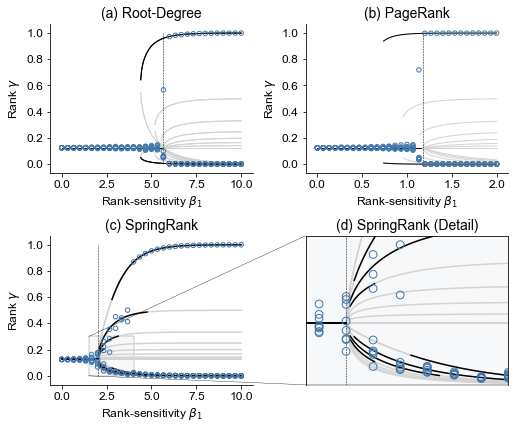

In [27]:
fig, axarr = plt.subplots(2,2, figsize = (7.2, 6))

b_grid = 31

BETA_VECS = [
    np.linspace(0, 10, b_grid),
    np.linspace(1.5, 4, b_grid),
    np.linspace(0, 2, b_grid),
    np.linspace(0, 10, b_grid)
]

lam = .9995
n_rounds = 50000

A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

ax_mapper = {
    (0,0): 3,
    (0,1): 2,
    (1,0): 0,
    (1,1): 1
}

for i in range(2):
    for j in range(2):
        if (i,j) in ax_mapper.keys():
            h = ax_mapper[(i,j)]
        
        ax = axarr[i][j]
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
#         if (i,j) == (0,0):
        ax.set(xlabel = r'Rank-sensitivity $\beta_1$')
        ax.set(ylabel = r'Rank $\gamma$')
#         else:
#         ax.set(xlabel = r'$\beta$')
#         ax.set(ylabel = r'$\gamma$')
            
        # BETAS = BETA_VECS[h]
        df = dfs[h]

        # df = df[df.beta <= BETAS.max()]
        # df = df[df.beta >= BETAS.min()]
        
        if i == 0:
            p = df.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.gamma_1, 
                                                                            zorder = 1,
                                                                            color = 'lightgrey', 
                                                                            linewidth = 1))

            p = df.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.gamma_2, 
                                                                            zorder = 1, 
                                                                            color = 'lightgrey', 
                                                                            linewidth = 1))

            df_sub = df[df.stable]

            p = df_sub.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.gamma_1, 
                                                                            zorder = 1, 
                                                                            color = 'black', 
                                                                            linewidth = 1))

            p = df_sub.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.gamma_2, 
                                                                            zorder = 1, 
                                                                            color = 'black', 
                                                                            linewidth = 1))
            
        else:
            p = df_SR.groupby(['n_1']).apply(lambda g: ax.plot(g.beta, g.gamma_1, zorder = 1, color = "lightgrey"))

            df_SR['group'] = df_SR.n_1
            df_SR['group'][df_SR.beta<2.00001] = -1
            df_SR[df_SR.stable].groupby(['n_1', 'group']).apply(lambda g: ax.plot(g.beta, g.gamma_1, zorder = 1, color = "black"))
            
            p = df_SR.groupby(['n_1']).apply(lambda g: ax.plot(g.beta, g.gamma_2, zorder = 1, color = "lightgrey"))

            df_SR['group'] = df_SR.n_1
            df_SR['group'][df_SR.beta<2.00001] = -1
            df_SR[df_SR.stable].groupby(['n_1', 'group']).apply(lambda g: ax.plot(g.beta, g.gamma_2, zorder = 1, color = "black"))

            
        
        ax.set(title = labels[h])
        ax.vlines(x = instabilities[h], ymin = 0, ymax = 1, linewidth = .5, linestyle = 'dashed')
        ax.vlines(x = emergence[h], ymin = 0, ymax = 1, linewidth = .5, linestyle = 'dotted')
    

    
        if h == 1:
            for k in range(V.shape[1]):
                p = ax.scatter(BETAS, V[:,k], alpha = 1, s=60, zorder = 2, facecolors='none', edgecolors = cset[0])        
        else:
            BETAS = BETA_VECS[h]

            M = model()
            M.set_score(score_function = scores[h])
            M.set_features([linear_feature])

            V = np.zeros((b_grid, n))

            for ell in range(b_grid):
                M.simulate(beta = np.array([BETAS[ell]]), 
                                    lam = lam, 
                                    A0 = A0, 
                                    n_rounds = n_rounds, 
                                    update = stochastic_update, 
                                    m_updates = 1)
                
                GAMMA = M.get_rates()
                GAMMA = np.sort(GAMMA, axis = 2)
                V[ell] = GAMMA[(-500):(-1)].mean(axis = (0,1))

            for k in range(V.shape[1]):
                p = ax.scatter(BETAS, V[:,k], alpha = 1, s=20, zorder = 2, facecolors='none', edgecolors = cset[0])

axarr[1][1].set(xlim = (1.5, 4.0))

axarr[1][1].set(ylim = (0, 0.3))

# axarr[0][1].spines['bottom'].set_visible(False)
# axarr[0][1].spines['left'].set_visible(False)
axarr[1][1].tick_params(bottom="off", left="off")


for pos in ['top', 'right', 'bottom', 'left']:
    axarr[1][1].spines[pos].set_visible(True)
    axarr[1][1].spines["bottom"].set_linewidth(.45)

axarr[1][1].set_xticklabels([])
axarr[1][1].set_yticklabels([])
axarr[1][1].axes.get_yaxis().set_visible(False)
axarr[1][1].axes.get_xaxis().set_visible(False)

rect = patches.Rectangle((1.5,0),2.5,.3, linewidth=1, edgecolor='none', linestyle='dashed',facecolor='slategray', alpha = .05)
axarr[1][0].add_patch(rect)

rect = patches.Rectangle((1.5,0), 2.5,.3, linewidth=.2, edgecolor='black', facecolor='none', alpha = 1)
axarr[1][0].add_patch(rect)

# axarr[0][1].axis('off')
axarr[1][1].set_facecolor((0.4375, 0.5, 0.5625, 0.05))



con1 = ConnectionPatch(xyA=(1.5, 0.3), xyB=(1.5, 0.3), coordsA="data", coordsB="data",
                      axesA=axarr[1][0], axesB=axarr[1][1], color="black", linewidth=.35, alpha = 1)
con2 = ConnectionPatch(xyA=(1.5, 0.0), xyB=(1.5, 0.0), coordsA="data", coordsB="data",
                      axesA=axarr[1][0], axesB=axarr[1][1], color="black", linewidth=.35, alpha = 1)

axarr[1][0].add_artist(con1)
axarr[1][0].add_artist(con2)

plt.tight_layout()
plt.savefig('fig/bifurcations_with_curves.png', dpi = 300, bbox_inches = 'tight')